In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
from sklearn.metrics import *

# Preparing data
Using data from [Hugging face](https://huggingface.co/datasets/tweets_hate_speech_detection)

Working reference by Paper
* [Journal 1](https://arxiv.org/pdf/1706.00188v1.pdf)
* [Journal 2](https://dl.acm.org/doi/pdf/10.1145/3447535.3462484)
* [Journal 3](https://arxiv.org/pdf/1803.08977v1.pdf)
* [Journal 4](https://arxiv.org/pdf/2104.10513v1.pdf)


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

## load data to DataFrame

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

In [ ]:
def load_datasets(data,target_data):
  result_dict={}
  data_train=data[target_data]
  texts=[]
  label=[]
  for text,labels in zip(data_train['tweet'],data_train['label']):
    texts.append(text)
    label.append(labels)
  result_dict={
    "tweet":texts,
    "labels":label
  }
  return result_dict

In [ ]:
train_df_datasets=load_datasets(data=dataset,target_data='train')

In [ ]:
data_train_df=pd.DataFrame(train_df_datasets)

In [ ]:
data_train_df

,tweet,labels
0,@user when a father is dysfunctional and is so...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
...,...,...
31957,ate @user isz that youuu?ðððððð...,0
31958,to see nina turner on the airwaves trying to w...,0
31959,listening to sad songs on a monday morning otw...,0
31960,"@user #sikh #temple vandalised in in #calgary,...",1


# EDA

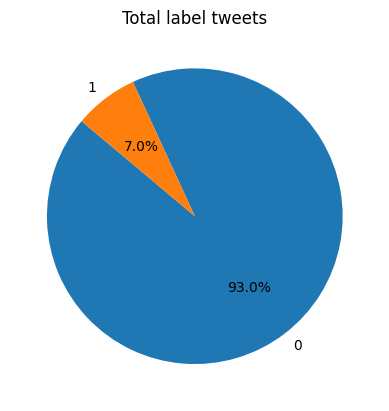

In [ ]:
plt.pie(x=data_train_df['labels'].value_counts(),labels=data_train_df['labels'].unique(),autopct='%1.1f%%',startangle=140)
plt.title("Total label tweets")
plt.show()

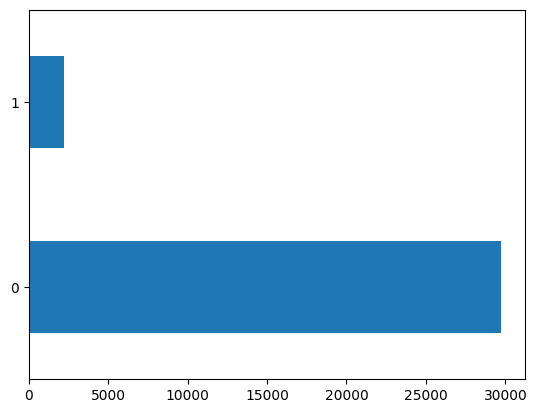

In [ ]:
data_train_df.labels.value_counts().plot.barh();

`Looks like`
* 0 label is not hate
* 1 labels is hate speech
* not hate aka 0 is most common label than label 1 (hate speech)



## Vector words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
bag_of_words=CountVectorizer()
corpus=data_train_df['tweet']
bag_of_words_tweets=bag_of_words.fit_transform(corpus).toarray()

In [ ]:
data_bag_of_words=pd.DataFrame({
    'features':bag_of_words.get_feature_names_out(),
    'scores_freq':bag_of_words_tweets.sum(axis=0)
})
top_ten_most_words_bag_of_words=data_bag_of_words.sort_values(by='scores_freq',ascending=False).head(10)

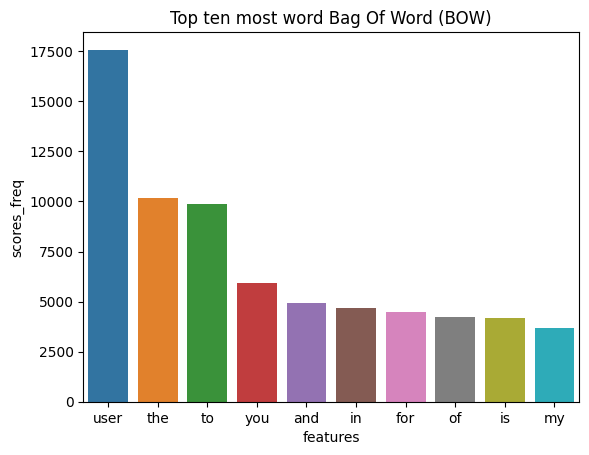

In [ ]:
sns.barplot(data=top_ten_most_words_bag_of_words,x='features',y='scores_freq')
plt.title('Top ten most word Bag Of Word (BOW)')
plt.show()

the ten words that appear the most are stopwords
* the
* to
* you
* and
* in
* for
* of
* is
* my

And must doing preprocessing
* Casefolding
* Remove stopwords
* Remove punctuation and number
* Stemming

## Total lines

In [ ]:
data_train_df['total_lines_before_preprocess']=data_train_df['tweet'].apply(lambda n : len(n.split()))

In [ ]:
data_train_df

,tweet,labels,total_lines_before_preprocess
0,@user when a father is dysfunctional and is so...,0,18
1,@user @user thanks for #lyft credit i can't us...,0,19
2,bihday your majesty,0,3
3,#model i love u take with u all the time in ...,0,14
4,factsguide: society now #motivation,0,4
...,...,...,...
31957,ate @user isz that youuu?ðððððð...,0,5
31958,to see nina turner on the airwaves trying to w...,0,23
31959,listening to sad songs on a monday morning otw...,0,13
31960,"@user #sikh #temple vandalised in in #calgary,...",1,10


In [ ]:
data_train_df['tweet'][0]

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

Check distribution length tweets

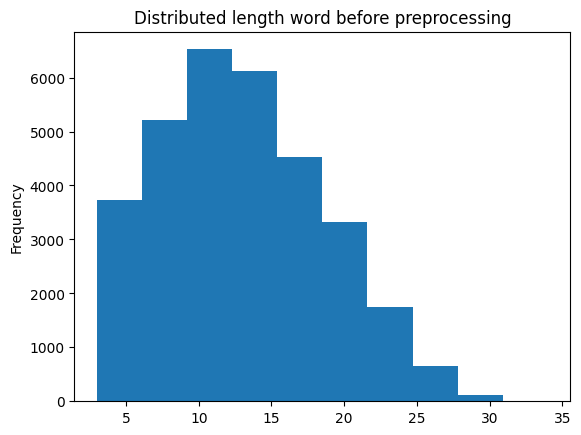

In [ ]:
data_train_df['total_lines_before_preprocess'].plot.hist();
plt.title("Distributed length word before preprocessing")
plt.show()

Okay, looks like most of the tweets are around 5 to 25 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

# Baseline model

In [ ]:
X_korpus=data_train_df['tweet']
y_label=data_train_df['labels']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_korpus, y_label, test_size=0.1, random_state=42)

In [ ]:
print(f'Total data train: {len(X_train)}')
print(f'Total data test: {len(X_test)}')

Total data train: 28765
Total data test: 3197


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

### Naives bayes

In [ ]:
model_naivesBayes=Pipeline([
    ('count vector',CountVectorizer()),
    ('Niaves bayes',MultinomialNB())
])


In [ ]:
model_naivesBayes.fit(X_train,y_train)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('Niaves bayes', MultinomialNB())])

### KNN

In [ ]:
model_knn=Pipeline([
    ('count vector',CountVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [ ]:
model_knn.fit(X_train,y_train)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

How to get vocabulary

In [ ]:
model_knn['count vector'].vocabulary_

{'ur': 35867,
 'welcome': 37012,
 'teammates': 33536,
 'dance': 8896,
 'to': 34513,
 'the': 33863,
 'tune': 35252,
 'of': 24564,
 'joyfulness': 18478,
 'enjoying': 11306,
 'sunshine': 32853,
 'finally': 12599,
 'got': 14668,
 'it': 17949,
 'framed': 13246,
 'thanks': 33819,
 'georgiana_draghici': 14040,
 'am44': 2049,
 'vfb': 36210,
 'stuttga': 32588,
 'football': 13084,
 'millions': 22076,
 'people': 25820,
 'will': 37428,
 'go': 14382,
 'bed': 3899,
 'tonight': 34618,
 'and': 2222,
 'wake': 36568,
 'up': 35813,
 'with': 37558,
 'stiff': 32273,
 'neck': 23392,
 'headache': 15659,
 'or': 24948,
 'numbness': 24393,
 'in': 17144,
 'their': 33973,
 'hands': 15350,
 'user': 35917,
 'allahsoil': 1871,
 'cold': 7466,
 'war': 36668,
 'was': 36701,
 'fought': 13189,
 'over': 25177,
 'oil': 24637,
 'teambts': 33502,
 'teamsuperjunior': 33552,
 '09': 41,
 '06': 24,
 '2016': 378,
 'throwback': 34301,
 'thursday': 34326,
 'remember': 28484,
 'hana': 15329,
 'kimi': 19001,
 'wu': 37941,
 'chun': 70

#### Evaluation

In [ ]:
classes_=model_knn['KNN'].classes_
classes_

array([0, 1])

In [ ]:
predict_knn=model_knn.predict(X_test)

In [ ]:
predict_knn

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
wrong_predict_knn_=(y_test!=predict_knn).sum()
correct_predict_knn_=(y_test==predict_knn).sum()

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
result_knn=calculate_results(y_test,predict_knn)
result_knn

{'accuracy': 94.65123553331249,
 'precision': 0.9385045421514765,
 'recall': 0.9465123553331248,
 'f1': 0.9352107137904165}

In [ ]:
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test,predict_knn).ravel()

In [ ]:
labels_true_hate_speech=(y_test==0).sum()
label_true_not_hate=(y_test!=0).sum()

In [ ]:
predict_hate_label=(predict_knn==0).sum()
predict_not_hate_label=(predict_knn==1).sum()

In [ ]:
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test,y_pred=predict_knn))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3115
Total predict not hate label : 82
Wrong prediction: 171
Correct prediction: 3026

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2984
           1       0.76      0.29      0.42       213

    accuracy                           0.95      3197
   macro avg       0.85      0.64      0.70      3197
weighted avg       0.94      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [ ]:
pd.DataFrame(classification_report(y_true=y_test,y_pred=predict_knn,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.951525,0.756098,0.946512,0.853811,0.938505
recall,0.993298,0.291080,0.946512,0.642189,0.946512
f1-score,0.971963,0.420339,0.946512,0.696151,0.935211
support,2984.000000,213.000000,0.946512,3197.000000,3197.000000


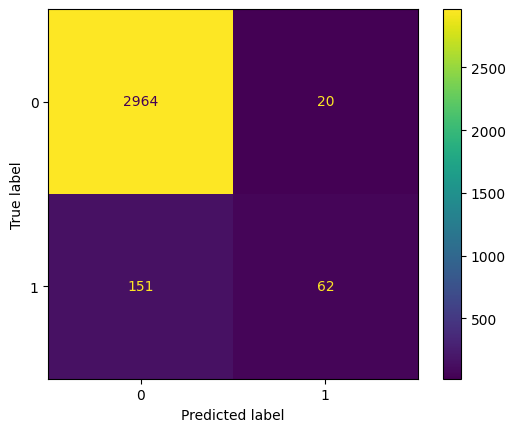

In [ ]:
cm_knn = confusion_matrix(y_test, predict_knn, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=classes_)
disp.plot()
plt.show()

In [ ]:
print(f'true positive: {tp_knn}')
print(f'true negatif: {tn_knn}')
print(f'false positive: {fp_knn}')
print(f'false negative: {fn_knn}')

true positive: 62
true negatif: 2964
false positive: 20
false negative: 151


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline